Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that load_imgs write to a DataFrame rather than an array

In [1]:
import config
import helper_fxns as hf
import transforms as tr
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import requests
import sys
import time
%matplotlib inline

In [116]:
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(config)
C = config.Config()

In [117]:
def add_voi(voi_df, acc_num, x, y, z, cls=None, flipz=None, return_id=False):
    """Append voi info to the dataframe voi_df. Overwrite any previous entries."""
    
    if return_id:
        row_id = hf.get_voi_id(acc_num, x, y, z)
    else:
        row_id = acc_num
    
    voi_df = voi_df[voi_df["id"] != row_id]
    
    if len(voi_df) == 0:
        i = 0
    else:
        i = voi_df.index[-1]+1
        
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]
    
    if return_id:
        voi_df.loc[i] = [str(acc_num) + ".npy", x[0], x[1], y[0], y[1], z[0], z[1], cls, flipz, dx, dy, dz, row_id]
        return voi_df, row_id
        
    else:
        voi_df.loc[i] = [row_id, x[0], x[1], y[0], y[1], z[0], z[1], dx, dy, dz]
        return voi_df

In [118]:
def add_to_dims_df(dims_df, acc_num, cur_dims):
    """Append scale info to the dataframe dims_df. Overwrite any previous entries."""
    
    dims_df = dims_df[dims_df["AccNum"] != acc_num]
    
    if len(dims_df) == 0:
        i = 0
    else:
        i = dims_df.index[-1] + 1
        
    dims_df.loc[i] = [acc_num] + list(cur_dims)
    
    return dims_df

In [119]:
def preprocess_df(df):
    """Select only rows for this run. Collect acc_nums and voi coordinates."""
    
    df = df[df['Run'] <= C.run_num].dropna(subset=["x1"])
    
    return df.drop(set(df.columns).difference(['Patient E Number', 
          'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'Image type', 'Flipped',
          'x3', 'x4', 'y3', 'y4', 'z3', 'z4', 'Image type2',
          'x5', 'x6', 'y5', 'y6', 'z5', 'z6', 'Image type3']), axis=1)

In [134]:
df = pd.read_excel(xls_name, sheetname=sheetname)

In [135]:
set(df.columns)

{'Flipped',
 'Image type',
 'Patient E Number',
 'Run',
 'x1',
 'x2',
 'y1',
 'y2',
 'z1',
 'z2'}

In [120]:
def load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df, verbose=False, target_dims = [1.5, 1.5, 4], num_ch=3):
    """Load images stored in img_dir with class name cls and stored in excel spreadsheet xls_name with name sheetname.
    Saves images to save_dir and saves vois to the global vois variable.
    Scales images and VOIs so that each voxel is 1.5 x 1.5 x 4 cm
    """
    
    s = time.time()
    print("\nLoading DCMs of type", sheetname)
    df = pd.read_excel(xls_name, sheetname=sheetname)
    df = preprocess_df(df)
    acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

    for cnt, acc_num in enumerate(acc_nums):
        if os.path.exists(save_dir + "\\" + str(acc_num) + ".npy"):
            print(acc_num, "has already been saved. Skipping.")
            continue
            
        df_subset = df.loc[df['Patient E Number'].astype(str) == acc_num]
        subdir = img_dir+"\\"+acc_num
        art, cur_dims = hf.dcm_load(subdir+r"\T1_AP")
        try:
            ven, _ = hf.dcm_load(subdir+r"\T1_VP")
        except:
            print(subdir+r"\T1_VP", "missing")
            continue

        # register phases if venous was not specified separately
        if "Image type2" not in df_subset.columns or df_subset.iloc[0]["Image type2"] != "VP-T1":
            ven, _ = hf.reg_imgs(moving=ven, fixed=art, params=params, rescale_only=False)
            
        dims_df = add_to_dims_df(dims_df, acc_num, cur_dims)

        if num_ch == 3:
            try:
                eq, _ = hf.dcm_load(subdir+r"\T1_EQ")
            except:
                print(subdir+r"\T1_EQ", "missing")
                continue
            if "Image type3" not in df_subset.columns or df_subset.iloc[0]["Image type3"] != "EQ-T1":
                eq, _ = hf.reg_imgs(moving=eq, fixed=art, params=params, rescale_only=False)
            img = np.transpose(np.stack((art, ven, eq)), (1,2,3,0))
        else:
            img = np.transpose(np.stack((art, ven)), (1,2,3,0))
            
        img, vox_scale = hf.rescale(img, target_dims, cur_dims)
        np.save(save_dir + "\\" + str(acc_num), img)

        if verbose:
            print(acc_num, "%d out of %d acc_nums loaded" % (cnt+1, len(acc_nums)))
        else:
            print(".", end="")
            
    print("Overall time: %s" % str(time.time() - s))
    return dims_df

In [121]:
def remove_voi(voi_df_art, voi_df_ven, acc_num, voi_num):
    try:
        voi_row = voi_df_art[voi_df_art["Filename"] == acc_num + ".npy"].iloc[voi_num]
        if len(voi_df_ven[voi_df_ven["id"] == voi_row["id"]]) > 0:
            voi_df_ven = voi_df_ven[voi_df_ven["id"] != voi_row["id"]]
        voi_df_art = voi_df_art[voi_df_art["id"] != voi_row["id"]]
        
    except:
        print(acc_num, "with lesion number", voi_num, "not found.")
        
    return voi_df_art, voi_df_ven

In [122]:
def load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df, verbose=False, target_dims = [1.5, 1.5, 4]):
    """TBD"""
    
    s = time.time()
    print("\nLoading VOIs for class", cls)
    
    voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
    df = pd.read_excel(xls_name, sheetname=sheetname)
    df = preprocess_df(df)
    
    acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

    for cnt, acc_num in enumerate(acc_nums):
        df_subset = df.loc[df['Patient E Number'].astype(str) == acc_num]
        img = np.load(save_dir + "\\" + str(acc_num) + ".npy")
        
        for _, row in df_subset.iterrows():
            x = (int(row['x1']), int(row['x2']))
            y = (int(row['y1']), int(row['y2']))
            z = (int(row['z1']), int(row['z2']))
            
            try:
                cur_dims = dims_df[dims_df["AccNum"] == acc_num].iloc[0].values[1:]
            except:
                print("dims_df not yet loaded for", acc_num)
            vox_scale = [float(cur_dims[i]/target_dims[i]) for i in range(3)]
            x,y,z = hf.scale_vois(x, y, z, vox_scale)
            
            y = (img.shape[1]-y[1], img.shape[1]-y[0]) # flip y
            if row['Flipped'] != "Yes":
                z = (img.shape[2]-z[1], img.shape[2]-z[0]) # flip z
            
            voi_df_art, art_id = add_voi(voi_df_art, acc_num, x,y,z, cls=cls, flipz=(row['Flipped'] == "Yes"), return_id = True)

            if "Image type2" in row.keys() and row['Image type2'] == 'VP-T1':
                x = (int(row['x3']), int(row['x4']))
                y = (int(row['y3']), int(row['y4']))
                z = (int(row['z3']), int(row['z4']))
                
                x,y,z = hf.scale_vois(x, y, z, vox_scale)
                
                y = (img.shape[1]-y[1], img.shape[1]-y[0]) # flip y
                if row['Flipped'] != "Yes":
                    z = (img.shape[2]-z[1], img.shape[2]-z[0]) # flip z
                    
                voi_df_ven = add_voi(voi_df_ven, art_id, x,y,z)
                
            if "Image type3" in row.keys() and row['Image type3'] == 'EQ-T1':
                x = (int(row['x5']), int(row['x6']))
                y = (int(row['y5']), int(row['y6']))
                z = (int(row['z5']), int(row['z6']))
                
                x,y,z = hf.scale_vois(x, y, z, vox_scale)
                
                y = (img.shape[1]-y[1], img.shape[1]-y[0]) # flip y
                if row['Flipped'] != "Yes":
                    z = (img.shape[2]-z[1], img.shape[2]-z[0]) # flip z
                    
                voi_df_eq = add_voi(voi_df_eq, art_id, x,y,z)

        if verbose:
            print(acc_num, "%d out of %d acc_nums loaded" % (cnt+1, len(acc_nums)))
        else:
            print(".", end="")
            
    print("Overall time: %s" % str(time.time() - s))
    return voi_df_art, voi_df_ven, voi_df_eq

In [123]:
def delete_imgs(acc_nums, xls_name=None, sheetname=None):
    if xls_name is not None:
        df = pd.read_excel(xls_name, sheetname=sheetname)
        df = preprocess_df(df)

        acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))
    
    for acc_num in acc_nums:
        os.remove(C.full_img_dir + "\\" + str(acc_num) + ".npy")

In [124]:
def check_folders(xls_name, sheetname):
    df = pd.read_excel(xls_name, sheetname=sheetname)
    df = preprocess_df(df)
    acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

    for cnt, acc_num in enumerate(acc_nums):
        df_subset = df.loc[df['Patient E Number'].astype(str) == acc_num]

        if not os.path.exists(img_dir + "\\" +acc_num + "\\T1_AP"):
            print(img_dir + "\\" +acc_num + "\\T1_AP is missing")
        if not os.path.exists(img_dir + "\\" +acc_num + "\\T1_VP"):
            print(img_dir + "\\" +acc_num + "\\T1_VP is missing")
        if not os.path.exists(img_dir + "\\" +acc_num + "\\T1_EQ"):
            print(img_dir + "\\" +acc_num + "\\T1_EQ is missing")

In [110]:
#dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls", "flipz", "dx", "dy", "dz", "id"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2", "dx", "dy", "dz"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2", "dx", "dy", "dz"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]

params = pyelastix.get_default_params(type="AFFINE")

In [117]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)

In [13]:
save_dir = C.full_img_dir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
xls_name = 'Z:\\Prototype1d.xlsx'
base_dir = "Z:"

### Run 1

In [107]:
delete_imgs(0, xls_name, sheetname)

In [111]:
img_dir = base_dir+'\\OPTN5A'
cls = 'hcc'
sheetname="OPTN 5A"
#check_folders(xls_name, sheetname)
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)


Loading VOIs for class hcc
.......Overall time: 0.630547046661377


In [125]:
img_dir = base_dir+'\\hemangioma'
cls = 'hemangioma'
sheetname="Hemangioma"
check_folders(xls_name, sheetname)
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
#voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)

Z:\hemangioma\12632037\T1_EQ is missing
Z:\hemangioma\12592283\T1_EQ is missing
Z:\hemangioma\13161325\T1_AP is missing
Z:\hemangioma\13161325\T1_VP is missing
Z:\hemangioma\13161325\T1_EQ is missing
Z:\hemangioma\12707781\T1_EQ is missing


In [ ]:
img_dir = base_dir+'\\optn5b'
cls = 'hcc'
sheetname="OPTN 5B"
#check_folders(xls_name, sheetname)
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)

In [ ]:
img_dir = base_dir+'\\simple_cysts'
cls = 'cyst'
sheetname="Cyst"
#check_folders(xls_name, sheetname)
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)

In [ ]:
voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)
#dims_df.to_csv(C.dims_df_path, index=False)

In [50]:
dims_df[dims_df["AccNum"] == "E101290891"]

,AccNum,x,y,z
199,E101290891,0.742188,0.742188,3.0


### Run 2

In [ ]:
img_dir = base_dir+'\\cholangio'
cls = 'cholangio'
sheetname="Cholangio"
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)
#check_folders(xls_name, sheetname)

In [90]:
img_dir = base_dir+'\\colorectal'
cls = 'colorectal'
sheetname="Colorectal"
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)
#check_folders(xls_name, sheetname)


Loading VOIs for class colorectal
..................Overall time: 1.786834955215454


In [91]:
img_dir = base_dir+'\\fnh'
cls = 'fnh'
sheetname="FNH"
#dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)
#check_folders(xls_name, sheetname)


Loading VOIs for class fnh
..........................Overall time: 2.5967462062835693


In [40]:
dims_df[dims_df["AccNum"] == 'E101266931']

,AccNum,x,y,z


### Run 3

In [97]:
img_dir = base_dir+'\\adenoma'
cls = 'adenoma'
sheetname="Adenoma"
dims_df = load_imgs(img_dir, xls_name, sheetname, save_dir, dims_df)
voi_dfs = load_vois(cls, xls_name, sheetname, save_dir, voi_dfs, dims_df)


Loading DCMs of type Adenoma
...............Overall time: 928.8483188152313


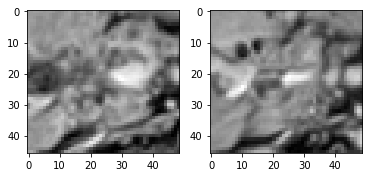

In [109]:
xls_name = 'Z:\\Prototype1b.xlsx'
base_dir = "Z:"#'raw_imgs'
#img_dir = base_dir+'\\hemangioma'
#cls = 'hemangioma'
#sheetname="Hemangioma"

need_dcm = False
acc_nums = ["12502068"]#list(set(df['Patient E Number'].dropna().astype(str).tolist()))
target_dims = [1.5, 1.5, 4]

if need_dcm:
    voi_df = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls", "flipz"])
    df = pd.read_excel(xls_name, sheetname)
    df = preprocess_df(df)
    for cnt, acc_num in enumerate(acc_nums):
        df_subset = df.loc[df['Patient E Number'].astype(str) == acc_num]
        subdir = img_dir+"\\"+acc_num
        art[acc_num], cur_dims = hf.dcm_load(subdir+r"\T1_AP")
        img = np.expand_dims(art[acc_num], axis=3)
        #img, vox_scale = hf.rescale(img, target_dims, cur_dims)

        np.save(save_dir + "\\" + acc_num, img)

        for _, row in df_subset.iterrows():
            x = (int(row['x1']), int(row['x2']))
            y = (int(row['y1']), int(row['y2']))
            z = (int(row['z1']), int(row['z2']))

            y = (art[acc_num].shape[1]-y[1], art[acc_num].shape[1]-y[0]) # flip y
            if row['Flipped'] != "Yes":
                z = (art[acc_num].shape[2]-z[1], art[acc_num].shape[2]-z[0]) # flip z

            #x,y,z = scale_vois(x, y, z, vox_scale)

            add_voi(acc_num, x,y,z, cls, row['Flipped'] != "Yes")
        
acc_num = acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+img_fn)
hf.plot_section(img, voi_df_art[voi_df_art["Filename"] == img_fn].iloc[0], flipz="both", pad=10)

In [22]:
pd.value_counts(voi_df_art['cls'])

cyst          75
hemangioma    44
Name: cls, dtype: int64

In [57]:
img_fn = "12799025.npy"
voi_df[voi_df["Filename"] == img_fn]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,dx,dy,dz
113,12789019.npy,104,123,89,106,28,34,hcc,True,19,17,6
114,12789019.npy,54,77,88,111,42,50,hcc,True,23,23,8


In [66]:
voi_df = hf.flipz(img_fn, voi_df)

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

In [ ]:
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[1], pad=10)

In [69]:
x = (74, 91)
y = (128, 145)
z = (43, 50)
y = (img.shape[1]-y[1], img.shape[1]-y[0]) # flip y
z = (img.shape[2]-z[1], img.shape[2]-z[0]) # flip z

In [27]:
hf.plot_section_xyz(img, x, y, z, pad=20)

NameError: name 'x' is not defined